##### Setup (imports, constants, etc.)

In [1]:
import multiprocessing
multiprocessing.set_start_method('forkserver')

In [67]:
from copy import deepcopy
import pdb
import warnings
from imp import reload
import time
from pprint import pprint
import random
from copy import deepcopy
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (StratifiedShuffleSplit, train_test_split,
                                     validation_curve)
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import (SelectKBest, chi2, mutual_info_classif,
                                       f_classif)
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import (LabelBinarizer, LabelEncoder,
                                   MinMaxScaler, StandardScaler,
                                   OneHotEncoder, Imputer)
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from IPython.display import display
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
from xgboost import XGBClassifier
from pyglmnet import GLM
from sklearn.utils.validation import check_is_fitted
from tpot import TPOTClassifier

import pdir

from outlier_detection import *
from preprocessing import (LogTransformer, SqrtTransformer, BedBathImputer,
                           LatLongImputer, LenExtractor, GroupSumExtractor,
                           WordCntExtractor, DayBinarizer, ItemSelector,
                           feature_prep)
from eda_plots import *
from validation_plots import *
from main import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.5f' % x)

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
SUBM_DIR = '../Submissions/'
TEST_DIR = '../Tests/'
REPORT_IMG_DIR = '../Report-Images/'
TPOT_DIR = './TPOT/'

TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
SAMPLE_FP = ''.join([DAT_DIR, 'sample_submission.csv'])
DF_TRAIN_PKL = ''.join([DAT_DIR, 'df_train.pkl'])
DF_TEST_PKL = ''.join([DAT_DIR, 'df_test.pkl'])

scorer_acc = make_scorer(accuracy_score)

# using built-in 'neg_log_loss' scoring param used for simplicity
# source code show exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                     needs_proba=True)

scoring = 'neg_log_loss'

df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notes

__About the target variable__:
- From Kaggle: "The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site."
- This means listings taken down quickly due to a quick close will be classified with the same interest level as one that takes longer to close and has the same number of inquiries.
- If we take a more holistic approach to interest level, another distortion could arise with listings that have lots of inquiries due to listings that are higher quality relative to the actual property.
- Ultimately, the distorting factor of duration is unknown because, assuming the listing were shown as they are now, the search ranking is determined not only by "freshness" but also by the quality of the posting and the property itself (possibly derived from interest level). 

__Dealing with class imbalance__:
- High: 0.078, medium: 0.228, low: 0.695
- https://stats.stackexchange.com/questions/122409/why-downsample
- For probabilistic models, we need that informatation of the imbalance!
- If balance, logloss worse than benchmark

__Logistic Regression__
- Cost function favors majority class, but so does the class distribution!
- ~~`Sklearn` implementation has `weight` parameter with `balanced` option.~~

__Dealing with outliers__:
- Examine with HDBSCAN
- Look at classes of outliers

__Logistic Regression__:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- `Liblinear` only compatible with `ovr`, use others for `multinomial`
- For build-in CV for regularization strength, use: [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

__Gradient boosted trees__:
- 

Stochastic Gradient Descent with modified huber loss:
- using sklearn's [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- `modified_huber` is another smooth loss that brings tolerance to outliers as well as probability estimates

__Train test split__

- 

# Learning

## Benchmarks

### Random guessing score:

In [3]:
df = read_rental_interest(DF_TRAIN_PKL)
y = LabelBinarizer().fit_transform(df.interest_level)

avg_probs = (np.sum(y, axis=0)/len(y)).tolist()
baseline_pred = np.array(avg_probs*len(y)).reshape(-1, 3)
baseline_score = log_loss(y, baseline_pred)
baseline_score

0.78857691143225461

### Basic Features
- Price (logged), Bedrooms, Bathrooms, Latitude, Longitude
- Binarized day created (Monday, Tuesday, etc.)
- Number of photos, features and description word count
- Indicator variables for zero values of counts above (ignored by XGBoost)

In [42]:
base_features = [
    'lg_price', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
    'n_photos', 'n_feats', 'descr_wcnt', 'no_photo', 'no_feats', 'no_desc',
    'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'
]

In [43]:
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_prepped = feature_prep(X).loc[:, base_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_prepped, y, random_state=SEED, stratify=y
)

cv = None  # default 3 fold


##### Logistic Regression

In [55]:
np.logspace(-4, 4, 9)

array([  1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
         1.00000000e-01,   1.00000000e+00,   1.00000000e+01,
         1.00000000e+02,   1.00000000e+03,   1.00000000e+04])

In [56]:
if 1 == 0:
    lr_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                                random_state=SEED)

    pipe = Pipeline([
        ('standardize', StandardScaler()),
        ('lr_clf', lr_clf)
    ])

    parameters = dict(
        lr_clf__C=np.logspace(-4, 4, 9),
    )
    grid = GridSearchCV(pipe, parameters, n_jobs=-1, scoring=scoring, cv=cv)

    %timeit -r1 -n1 grid.fit(X_train, y_train)

    print(best_grid_results(grid))

7.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best score: -0.69004

*** For parameters: ***
lr_clf__C: 0.10000


Train score:   -0.68831
Test score :   -0.68935

7.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


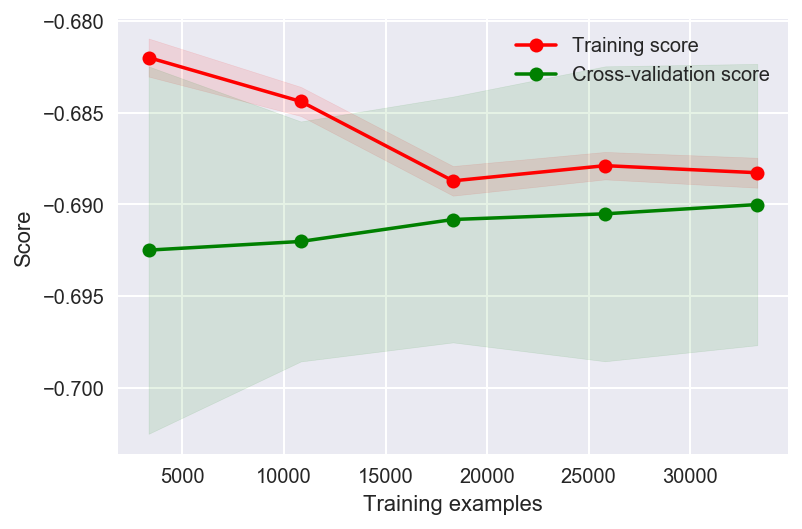

In [57]:
if 1 == 0:
    clf = grid.best_estimator_

    y_pred = clf.predict_proba(X_train)
    print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

    y_pred = clf.predict_proba(X_test)
    print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))
    print()

    # so %timeit works with multiline arguments
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  cv=10, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)

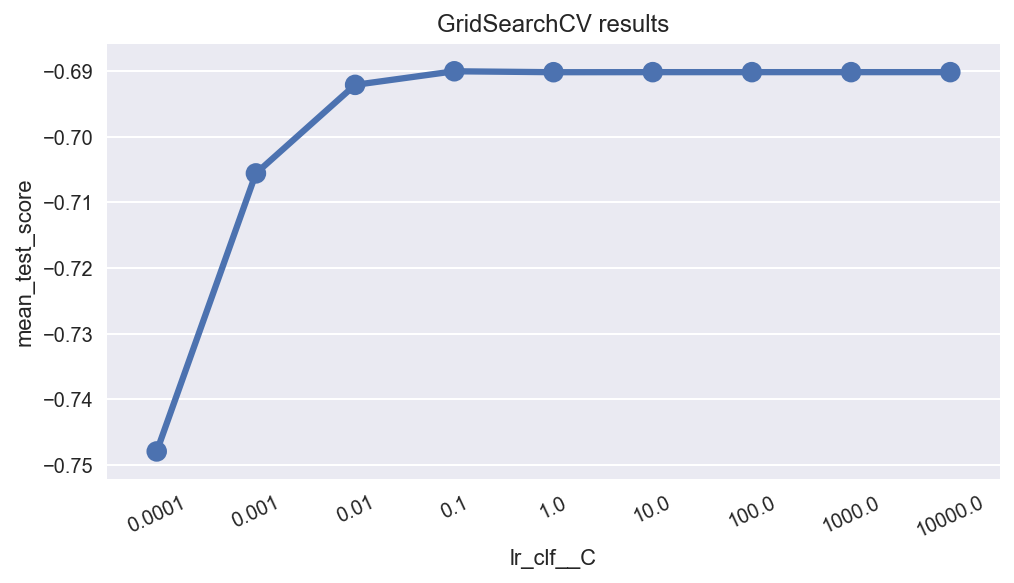

In [59]:
if 1 == 0:
    fig, ax = plt.subplots()

    gex = GridSearchExplorer(grid)

    gex.plot(x='lr_clf__C', metric='mean_test_score', kind='point', ax=ax)
    fig.set_figwidth(8)
    plt.xticks(rotation=25)
    plt.show()

##### XGBoost

In [60]:
if 1 == 0:
    xgb_clf = XGBClassifier(objective='multi:softprob', subsample=0.8, 
                            colsample_bytree=0.8, nthread=1, seed=SEED)

    parameters = dict(
        max_depth=[4, 5, 6, 7],
        learning_rate=[0.1, .15],
        n_estimators=[100, 150, 200],
    )
    grid = GridSearchCV(xgb_clf, parameters, n_jobs=-1, scoring=scoring, cv=cv)

    %timeit -r1 -n1 grid.fit(X_train, y_train)

    print(best_grid_results(grid))

4min 30s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best score: -0.61560

*** For parameters: ***
max_depth: 6.00000
learning_rate: 0.10000
n_estimators: 200.00000


Train score:   -0.49774
Test score :   -0.60884

59.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


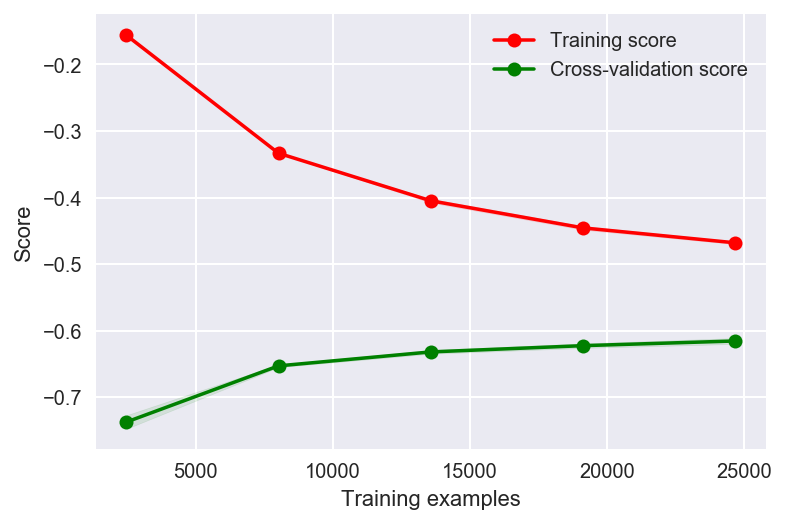

In [61]:
if 1 == 0:
    clf = grid.best_estimator_

    y_pred = clf.predict_proba(X_train)
    print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

    y_pred = clf.predict_proba(X_test)
    print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))
    print()

    # so %timeit works with multiline arguments
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  cv=cv, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)

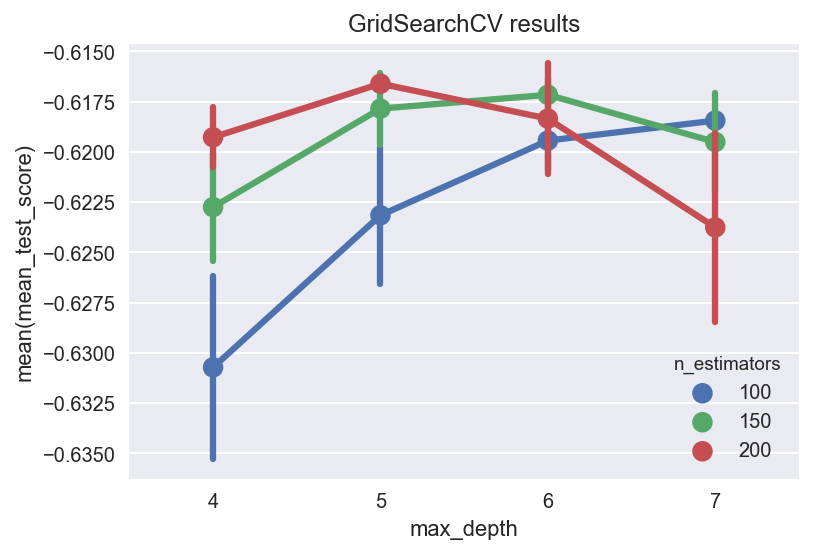

In [63]:
if 1 == 0:
    fig, ax = plt.subplots()

    gex = GridSearchExplorer(grid)

    gex.plot(x='max_depth', hue='n_estimators',
             metric='mean_test_score', kind='point', ax=ax)

##### TPOT

In [ ]:
if 1 == 1:

    tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
                          scoring='neg_log_loss', random_state=SEED, n_jobs=1,
                          config_dict='classifier_light.py'
    )
    tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export(''.join([TPOT_DIR, 'tpot_bench_light.py']))

Optimization Progress:  30%|███       | 36/120 [02:06<04:19,  3.09s/pipeline]

Generation 1 - Current best internal CV score: 0.6930710722925333


Optimization Progress:  47%|████▋     | 56/120 [13:58<37:13, 34.90s/pipeline]  

Generation 2 - Current best internal CV score: 0.692311442516971


Optimization Progress:  64%|██████▍   | 77/120 [23:49<13:48, 19.27s/pipeline]

Generation 3 - Current best internal CV score: 0.692311442516971


Optimization Progress:  78%|███████▊  | 94/120 [23:58<03:03,  7.07s/pipeline]

Generation 4 - Current best internal CV score: 0.692311442516971


In [ ]:
if 1 == 1:
    tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
                          scoring=scoring, random_state=SEED, n_jobs=1,
    )
    %timeit -r1 -n1 tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export(''.join([TPOT_DIR, 'tpot_bench.py']))

In [2]:
extractor = FeatureUnion([
    ('basic', FeatureUnion([
        ('pre_processed', ItemSelector(
            ['lg_price', 'n_photos', 'n_feats', 'descr_wcnt'])),
        ('coordinates', make_pipeline(
            ItemSelector(['latitude', 'longitude']),
            LatLongImputer(),
        )),
        ('rooms', make_pipeline(
            ItemSelector(['bathrooms', 'bedrooms']),
            BedBathImputer())),   
        ])),

    ('aggregate', make_pipeline(
        FeatureUnion([
            ('n_posts', make_pipeline(
                ItemSelector(['manager_id']),
                GroupSumExtractor())),
            ('building_activity', make_pipeline(
                ItemSelector(['building_id']),
                GroupSumExtractor()))
        ]),
        LogTransformer(),
    )),
    
    ('day_names', ItemSelector([
        'created_Friday', 'created_Monday', 'created_Saturday',
        'created_Sunday', 'created_Thursday', 'created_Tuesday',
        'created_Wednesday'
    ])),
    ('flags', ItemSelector(['no_photo', 'no_feats', 'no_desc']))
        
])

In [3]:
columns = [
    'latitude', 'longitude', 'lg_price', 'n_photos', 'n_feats',
    'descr_wcnt', 'bathrooms', 'bedrooms', 'n_posts', 'building_activity',
    'created_Friday', 'created_Monday', 'created_Saturday',
    'created_Sunday', 'created_Thursday', 'created_Tuesday',
    'created_Wednesday', 'no_photo', 'no_feats', 'no_desc'
]

In [7]:
df = read_rental_interest(DF_TRAIN_PKL)

X_, y = df.drop('interest_level', axis=1), df.interest_level

X = feature_prep(X_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.20, random_state=SEED, stratify=y)

pipe = Pipeline([
    ('extractor', extractor),
    ('standardize', StandardScaler()),
    ('lr_clf', LogisticRegression(
        random_state=SEED, multi_class='multinomial',
        warm_start=True, max_iter=100, 
        solver='lbfgs'))
])

parameters = dict(
    lr_clf__C=np.logspace(-4, 4, 10),
    lr_clf__solver=['newton-cg', 'lbfgs'],
)

cv = StratifiedShuffleSplit(n_splits=5, train_size=.4, random_state=SEED)
grid = GridSearchCV(pipe, parameters, n_jobs=-1, scoring=scoring,
                    error_score=np.nan, cv=cv)


%timeit -n1 -r1 grid.fit(X_train, y_train)

print(best_grid_results(grid))

KeyboardInterrupt: 

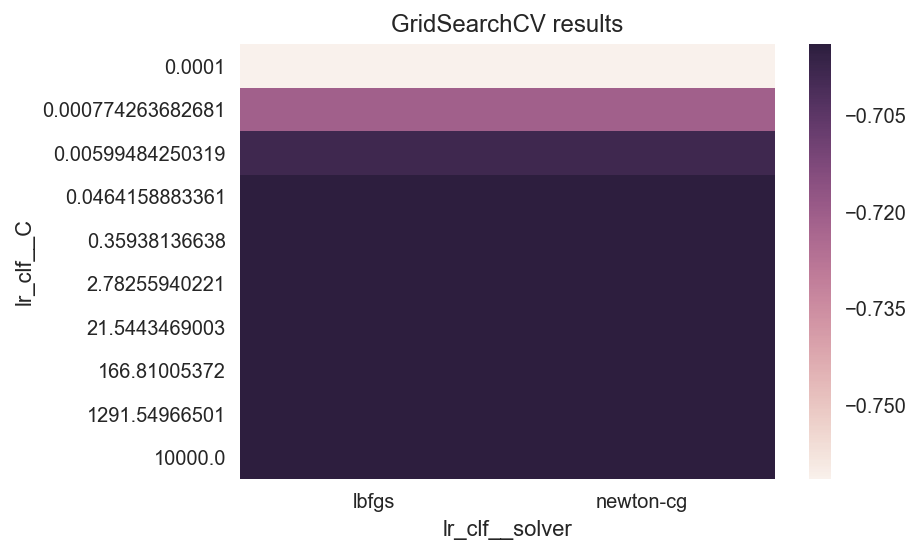

In [18]:
gex = GridSearchExplorer(grid)
gex.plot('lr_clf__solver')

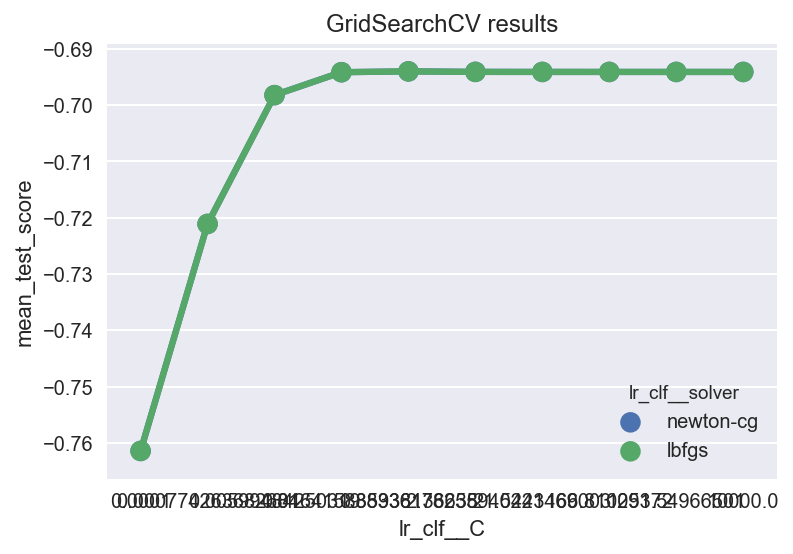

In [17]:
gex = GridSearchExplorer(grid)
gex.plot(hue='lr_clf__solver', x='lr_clf__C', kind='point')

In [8]:
grid.predict_proba(X_train.iloc[[0]])

array([[ 0.86330668,  0.12186012,  0.0148332 ]])

### Feature Selection

In [31]:
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_prepped = feature_prep(X).loc[:, base_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_prepped, y, test_size=.2, random_state=SEED, stratify=y
)

sgd_clf = SGDClassifier(random_state=SEED, loss='log', penalty='elasticnet')

pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('sgd_clf', sgd_clf)
])

parameters = dict(
    sgd_clf__l1_ratio=np.arange(0, 1.2, .2),
    sgd_clf__alpha=np.logspace(-6, 1, 10),
)

cv = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=SEED+1)
grid = GridSearchCV(pipe, parameters, n_jobs=-1, scoring=scoring, cv=cv)

%timeit -r1 -n1 grid.fit(X_train, y_train)

print(best_grid_results(grid))

gex = GridSearchExplorer(grid)
ax = gex.plot('sgd_clf__alpha', 'sgd_clf__l1_ratio', kind='point')

coefs = grid.best_estimator_.steps[1][1].coef_

pd.DataFrame(coefs, index=[1,2,3], columns=base_features)

pd.DataFrame(coefs, index=[1,2,3], columns=base_features)

9.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best score: -0.74483

*** For parameters: ***
sgd_clf__alpha: 0.00021544346900318845
sgd_clf__l1_ratio: 0.6000000000000001
